# Drug Pricing Project - Analysis

## Import Packages and Data

In [2]:
import csv
import re
import os
import nltk
import argparse
import itertools
import glob
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict, deque, OrderedDict
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from itertools import chain
pd.options.display.max_colwidth = 450
porter_stemmer = PorterStemmer()

In [3]:
import sys
sys.path.insert(0, '/Users/jackiereimer/Dropbox/Drug Pricing Project/code')

In [82]:
from reddit_preprocessing.reddit_preprocessing import reddit_preprocessing as rp
from snorkel.snorkel.models import Document, Sentence

In [5]:
class ArgumentContainer(object):
    def __init__(self):
        self.data_folder = "opiates"
        self.keyterm_folder = "keyterm_lists"
        self.complete_threads_file = "use_data/threads/all_dumps.csv"
        self.complete_comments_file = "use_data/comments/all_comments.csv"
        self.stop_words = "stop_words"
        self.location_folder = "location"
        self.mat_folder = "mat"
        self.unit_folder = "unit"
        self.currency_folder = "currency"
        self.output_folder = "output"
        self.file_folder = None


if 'args' not in dir():
    args = ArgumentContainer()

In [12]:
locations_filepath, mat_filepath, all_comments_filepath, all_dumps_filepath, unit_filepath, currency_filepath, output_filepath, stopwords_filepath = rp.assign_location_dirs(args.data_folder, args.complete_threads_file, args.complete_comments_file, args.location_folder, args.mat_folder, args.unit_folder, args.currency_folder, args.output_folder, args.stop_words, args.file_folder)
locations, state_init = rp.generates_non_case_sensitive_list_of_keyterms(locations_filepath)
meth_words, sub_words, nalt_words, narc_words = rp.generates_non_case_sensitive_list_of_keyterms(mat_filepath)
currencies = rp.generates_non_case_sensitive_list_of_keyterms(currency_filepath)[0]
units = rp.generates_non_case_sensitive_list_of_keyterms(unit_filepath)[0]
more_stops = rp.generates_non_case_sensitive_list_of_keyterms(stopwords_filepath)[0]

All thread file: /Users/jackiereimer/Dropbox/drug_pricing_data/opiates/use_data/threads/all_dumps.csv
All comment file: /Users/jackiereimer/Dropbox/drug_pricing_data/opiates/use_data/comments/all_comments.csv
Stop Words file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/stop_words
Locations file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/location
MAT file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/mat
Unit file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/unit
Currency file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/currency
Output folder: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/output
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/location/locations.csv
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/location/state_init.csv
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/mat/methadone_words.csv
/Users/jackiereimer/Drop

In [13]:
len(locations)

774

In [14]:
total_thread_tuples, total_threads = rp.list_of_threads_from_csv(args.data_folder, all_dumps_filepath)
total_comment_tuples, total_comments = rp.list_of_comments_from_csv(args.data_folder, all_comments_filepath)
total_posts = total_threads + total_comments
thread_tuples_headers = ['post_id','time','no_comments', 'post_title', 'post_body']
comment_tuples_headers = ['comment_id', 'time', 'reply_id', 'post_body']
stop = stopwords.words('english')
stop_all = stop + more_stops

All r/opiates/ threads aggregated
All r/opiates/ comments aggregated


## Put Data into DataFrame and Define Regex Filters

In [15]:
general_re = r"^.*\b({})\b.*$" # matches standalone strings
digit_re = r"\s\b\d{1,3}\b" # matches standalone numbers between 1 and 3 digits
price_re = r'^.*[{}]\s?\d{{1,3}}(?:[.,]\d{{3}})*(?:[.,]\d{{1,2}})?.*$' # matches standalone numbers of currency format with preceding currency symbol
unit_price_re = r'[{}]?\d+[/]\D\S+' # matches string of format 'digit(s)/letter(s)' (e.g. $40/gram, 5/mg)
surrounding_dollar_re = r'(?P<before>(?:\w+\W+){5})\$\d+(?:\.\d+)?(?P<after>(?:\W+\w+){5})' # matches the five words that surround the mention of '$'
surrounding_words_re = r'(?P<before>(?:\w+\W+){})[{}]\d+(?:\.\d+)?(?P<after>(?:\W+\w+){})' # requires three inputs (digit, keywords, digit), matches the digit number of words that surround keyword

In [16]:
def convert_key_word_threads_to_df(df, search_for, regexp, case_sensitive=False):
    """
    """
    print('Number of strings searched: %s' % df.shape[0])
    print('Number of keywords searching for: %s' % len(search_for))
    dt_start = datetime.datetime.now()
    print('Starting time:', dt_start)
    if not case_sensitive:
        flag = re.I
    else:
        flag = False
    i = 0
    new_df = df
    for keyword in search_for:
        i += 1
        print('Word %s out of %s' % (i, len(search_for)))
        print('Time elapsed:', datetime.datetime.now() - dt_start)
        word = re.compile(regexp.format(keyword), flags=flag)
        new_df[keyword] = new_df.astype(str).sum(axis=1).str.contains(word, regex=True)
    return new_df

In [17]:
comment_df = pd.DataFrame(total_comment_tuples, columns=comment_tuples_headers)
thread_df = pd.DataFrame(total_thread_tuples, columns=thread_tuples_headers)
reddit_df = thread_df.append(comment_df)
reddit_df = reddit_df[['time', 'post_id', 'reply_id', 'no_comments', 'comment_id', 'post_title', 'post_body']]
reddit_df = reddit_df.applymap(lambda s:s.lower() if type(s) == str else s)

### MAT DataFrames

In [36]:
narc_df = convert_key_word_threads_to_df(reddit_df, narc_words, general_re, case_sensitive=False)

Number of strings searched: 1998790
Number of keywords searching for: 7
Starting time: 2019-02-15 12:24:27.964262
Word 1 out of 7


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Time elapsed: 0:00:00.000484
Word 2 out of 7
Time elapsed: 0:00:51.689214
Word 3 out of 7
Time elapsed: 0:01:30.009921
Word 4 out of 7
Time elapsed: 0:02:14.711463
Word 5 out of 7
Time elapsed: 0:03:02.493681
Word 6 out of 7
Time elapsed: 0:03:48.169288
Word 7 out of 7
Time elapsed: 0:04:35.050139


In [37]:
meth_df = convert_key_word_threads_to_df(reddit_df, meth_words, general_re, case_sensitive=False)

Number of strings searched: 1998790
Number of keywords searching for: 8
Starting time: 2019-02-15 12:33:01.079427
Word 1 out of 8
Time elapsed: 0:00:00.000302


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Word 2 out of 8
Time elapsed: 0:00:48.266797
Word 3 out of 8
Time elapsed: 0:01:30.100390
Word 4 out of 8
Time elapsed: 0:02:14.773471
Word 5 out of 8
Time elapsed: 0:03:01.620924
Word 6 out of 8
Time elapsed: 0:03:49.202828
Word 7 out of 8
Time elapsed: 0:04:39.374605
Word 8 out of 8
Time elapsed: 0:05:30.380774


In [38]:
nalt_df = convert_key_word_threads_to_df(reddit_df, nalt_words, general_re, case_sensitive=False)

Number of strings searched: 1998790
Number of keywords searching for: 8
Starting time: 2019-02-15 12:39:24.496941
Word 1 out of 8
Time elapsed: 0:00:00.000755


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Word 2 out of 8
Time elapsed: 0:00:57.583150
Word 3 out of 8
Time elapsed: 0:01:56.667166
Word 4 out of 8
Time elapsed: 0:02:55.454659
Word 5 out of 8
Time elapsed: 0:03:54.911922
Word 6 out of 8
Time elapsed: 0:04:58.379969
Word 7 out of 8
Time elapsed: 0:06:01.327238
Word 8 out of 8
Time elapsed: 0:07:09.014016


In [39]:
sub_df = convert_key_word_threads_to_df(reddit_df, sub_words, general_re, case_sensitive=False)

Number of strings searched: 1998790
Number of keywords searching for: 10
Starting time: 2019-02-15 12:47:41.414117
Word 1 out of 10
Time elapsed: 0:00:00.006537


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Word 2 out of 10
Time elapsed: 0:01:09.018661
Word 3 out of 10
Time elapsed: 0:02:19.485146
Word 4 out of 10
Time elapsed: 0:03:31.684754
Word 5 out of 10
Time elapsed: 0:04:48.924736
Word 6 out of 10
Time elapsed: 0:06:39.612029
Word 7 out of 10
Time elapsed: 0:08:07.767835
Word 8 out of 10
Time elapsed: 0:09:44.057711
Word 9 out of 10
Time elapsed: 0:11:14.902373
Word 10 out of 10
Time elapsed: 0:12:53.703958


In [46]:
reddit_df.columns.values

array(['time', 'post_id', 'reply_id', 'no_comments', 'comment_id',
       'post_title', 'post_body', 'evzio', 'narcan', 'nrcn', 'narcn',
       'nrcan', 'naloxone', 'nar can', 'methadon', 'mthdne', 'methadoner',
       'methdone', 'mmt', 'methadone', 'mthadone', '`done', 'nal trexone',
       'depade', 'revia', 'nalts', 'naltrexone', 'uldn', 'nalt',
       'vivitrol', 'subs', 'bupes', 'suboxone', 'probuphine', 'suboxones',
       'sub', 'buprenex', 'butrans', 'belbuca', 'bupe'], dtype=object)

In [40]:
narc_only_df = reddit_df.loc[(reddit_df['narcan'] == True) | (reddit_df['nrcn'] == True) | (reddit_df['narcn'] == True) | (reddit_df['evzio'] == True) | (reddit_df['naloxone'] == True) | (reddit_df['nar can'] == True) | (reddit_df['nrcan'] == True)]
meth_only_df = reddit_df.loc[((reddit_df['`done'] == True) | (reddit_df['mmt'] == True) | (reddit_df['mthadone'] == True) | (reddit_df['mthdne'] == True) | (reddit_df['methadon'] == True) | (reddit_df['methadoner'] == True) | (reddit_df['methdone'] == True) | (reddit_df['methadone'] == True)) & ((reddit_df['revia'] != True) & (reddit_df['nalts'] != True) & (reddit_df['nal trexone'] != True) & (reddit_df['nalt'] != True) & (reddit_df['uldn'] != True) & (reddit_df['depade'] != True) & (reddit_df['naltrexone'] != True) & (reddit_df['vivitrol'] != True)) & ((reddit_df['sub'] != True) & (reddit_df['probuphine'] != True) & (reddit_df['belbuca'] != True) & (reddit_df['butrans'] != True) & (reddit_df['bupes'] != True) & (reddit_df['buprenex'] != True) & (reddit_df['subs'] != True) & (reddit_df['bupe'] != True) & (reddit_df['suboxone'] != True))]
nalt_only_df = reddit_df.loc[((reddit_df['`done'] != True) & (reddit_df['mmt'] != True) & (reddit_df['mthadone'] != True) & (reddit_df['mthdne'] != True) & (reddit_df['methadon'] != True) & (reddit_df['methadoner'] != True) & (reddit_df['methdone'] != True) & (reddit_df['methadone'] != True)) & ((reddit_df['revia'] == True) | (reddit_df['nalts'] == True) | (reddit_df['nal trexone'] == True) | (reddit_df['nalt'] == True) | (reddit_df['uldn'] == True) | (reddit_df['depade'] == True) | (reddit_df['naltrexone'] == True) | (reddit_df['vivitrol'] == True)) & ((reddit_df['sub'] != True) & (reddit_df['probuphine'] != True) & (reddit_df['belbuca'] != True) & (reddit_df['butrans'] != True) & (reddit_df['bupes'] != True) & (reddit_df['buprenex'] != True) & (reddit_df['subs'] != True) & (reddit_df['bupe'] != True) & (reddit_df['suboxone'] != True))]
sub_only_df = reddit_df.loc[((reddit_df['`done'] != True) & (reddit_df['mmt'] != True) & (reddit_df['mthadone'] != True) & (reddit_df['mthdne'] != True) & (reddit_df['methadon'] != True) & (reddit_df['methadoner'] != True) & (reddit_df['methdone'] != True) & (reddit_df['methadone'] != True)) & ((reddit_df['revia'] != True) & (reddit_df['nalts'] != True) & (reddit_df['nal trexone'] != True) & (reddit_df['nalt'] != True) & (reddit_df['uldn'] != True) & (reddit_df['depade'] != True) & (reddit_df['naltrexone'] != True) & (reddit_df['vivitrol'] != True)) & ((reddit_df['sub'] == True) | (reddit_df['probuphine'] == True) | (reddit_df['belbuca'] == True) | (reddit_df['butrans'] == True) | (reddit_df['bupes'] == True) | (reddit_df['buprenex'] == True) | (reddit_df['subs'] == True) | (reddit_df['bupe'] == True) | (reddit_df['suboxone'] == True))]

In [60]:
bins = np.linspace(1271701857.0, 1549857174.0, 25)

In [65]:
narc_time = narc_only_df['time']
meth_time = meth_only_df['time']
nalt_time = nalt_only_df['time']
sub_time = sub_only_df['time']

In [46]:
reddit_df['time_new'] = pd.to_datetime(reddit_df['time'], unit='s')
narc_only_df['time_new'] = pd.to_datetime(narc_only_df['time'], unit='s')
meth_only_df['time_new'] = pd.to_datetime(meth_only_df['time'], unit='s')
nalt_only_df['time_new'] = pd.to_datetime(nalt_only_df['time'], unit='s')
sub_only_df['time_new'] = pd.to_datetime(sub_only_df['time'], unit='s')

reddit_df['date'] = reddit_df['time_new'].dt.date
narc_only_df['date'] = narc_only_df['time_new'].dt.date
meth_only_df['date'] = meth_only_df['time_new'].dt.date
nalt_only_df['date'] = nalt_only_df['time_new'].dt.date
sub_only_df['date'] = sub_only_df['time_new'].dt.date

reddit_df['time_new'] = pd.to_datetime(reddit_df['time'], unit='s')
narc_only_df['time_new'] = pd.to_datetime(narc_only_df['time'], unit='s')
meth_only_df['time_new'] = pd.to_datetime(meth_only_df['time'], unit='s')
nalt_only_df['time_new'] = pd.to_datetime(nalt_only_df['time'], unit='s')
sub_only_df['time_new'] = pd.to_datetime(sub_only_df['time'], unit='s')

reddit_df['time'] = pd.to_numeric(reddit_df['time'])
narc_only_df['time'] = pd.to_numeric(narc_only_df['time'])
meth_only_df['time'] = pd.to_numeric(meth_only_df['time'])
nalt_only_df['time'] = pd.to_numeric(nalt_only_df['time'])
sub_only_df['time'] = pd.to_numeric(sub_only_df['time'])

reddit_df['date'] = pd.to_datetime(reddit_df['time_new'])
narc_only_df['date'] = pd.to_datetime(narc_only_df['time_new'])
meth_only_df['date'] = pd.to_datetime(meth_only_df['time_new'])
nalt_only_df['date'] = pd.to_datetime(nalt_only_df['time_new'])
sub_only_df['date'] = pd.to_datetime(sub_only_df['time_new'])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

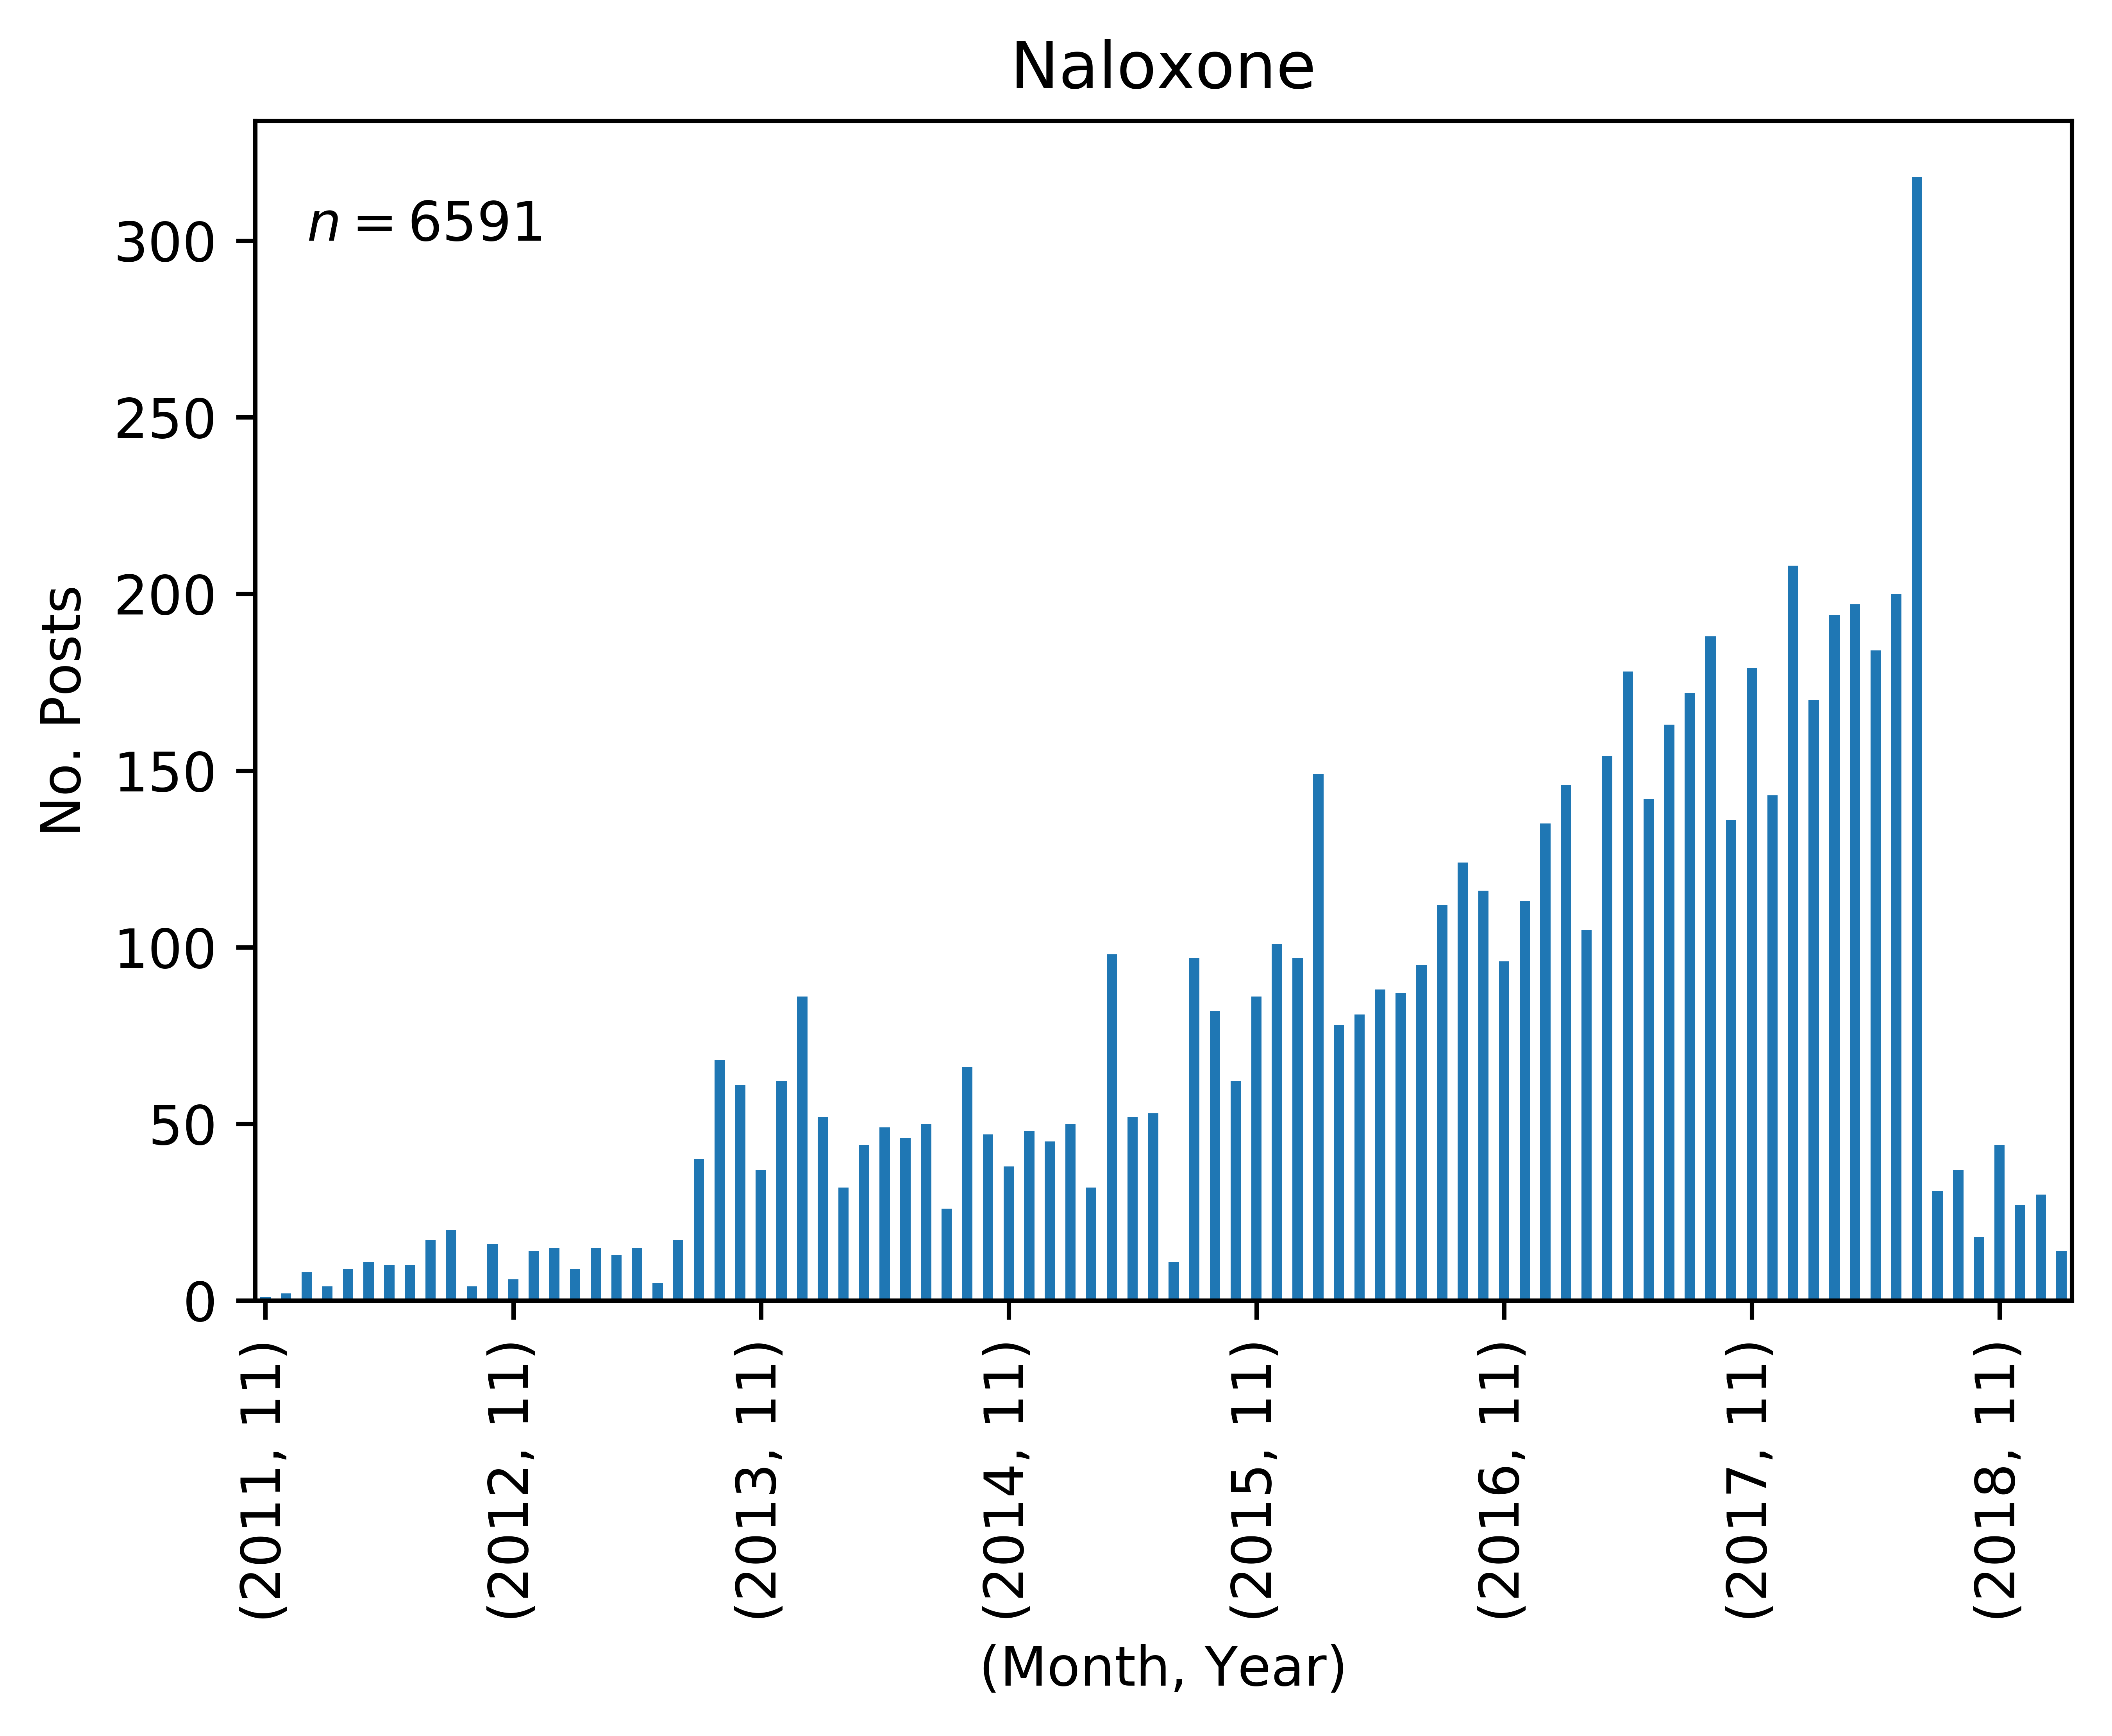

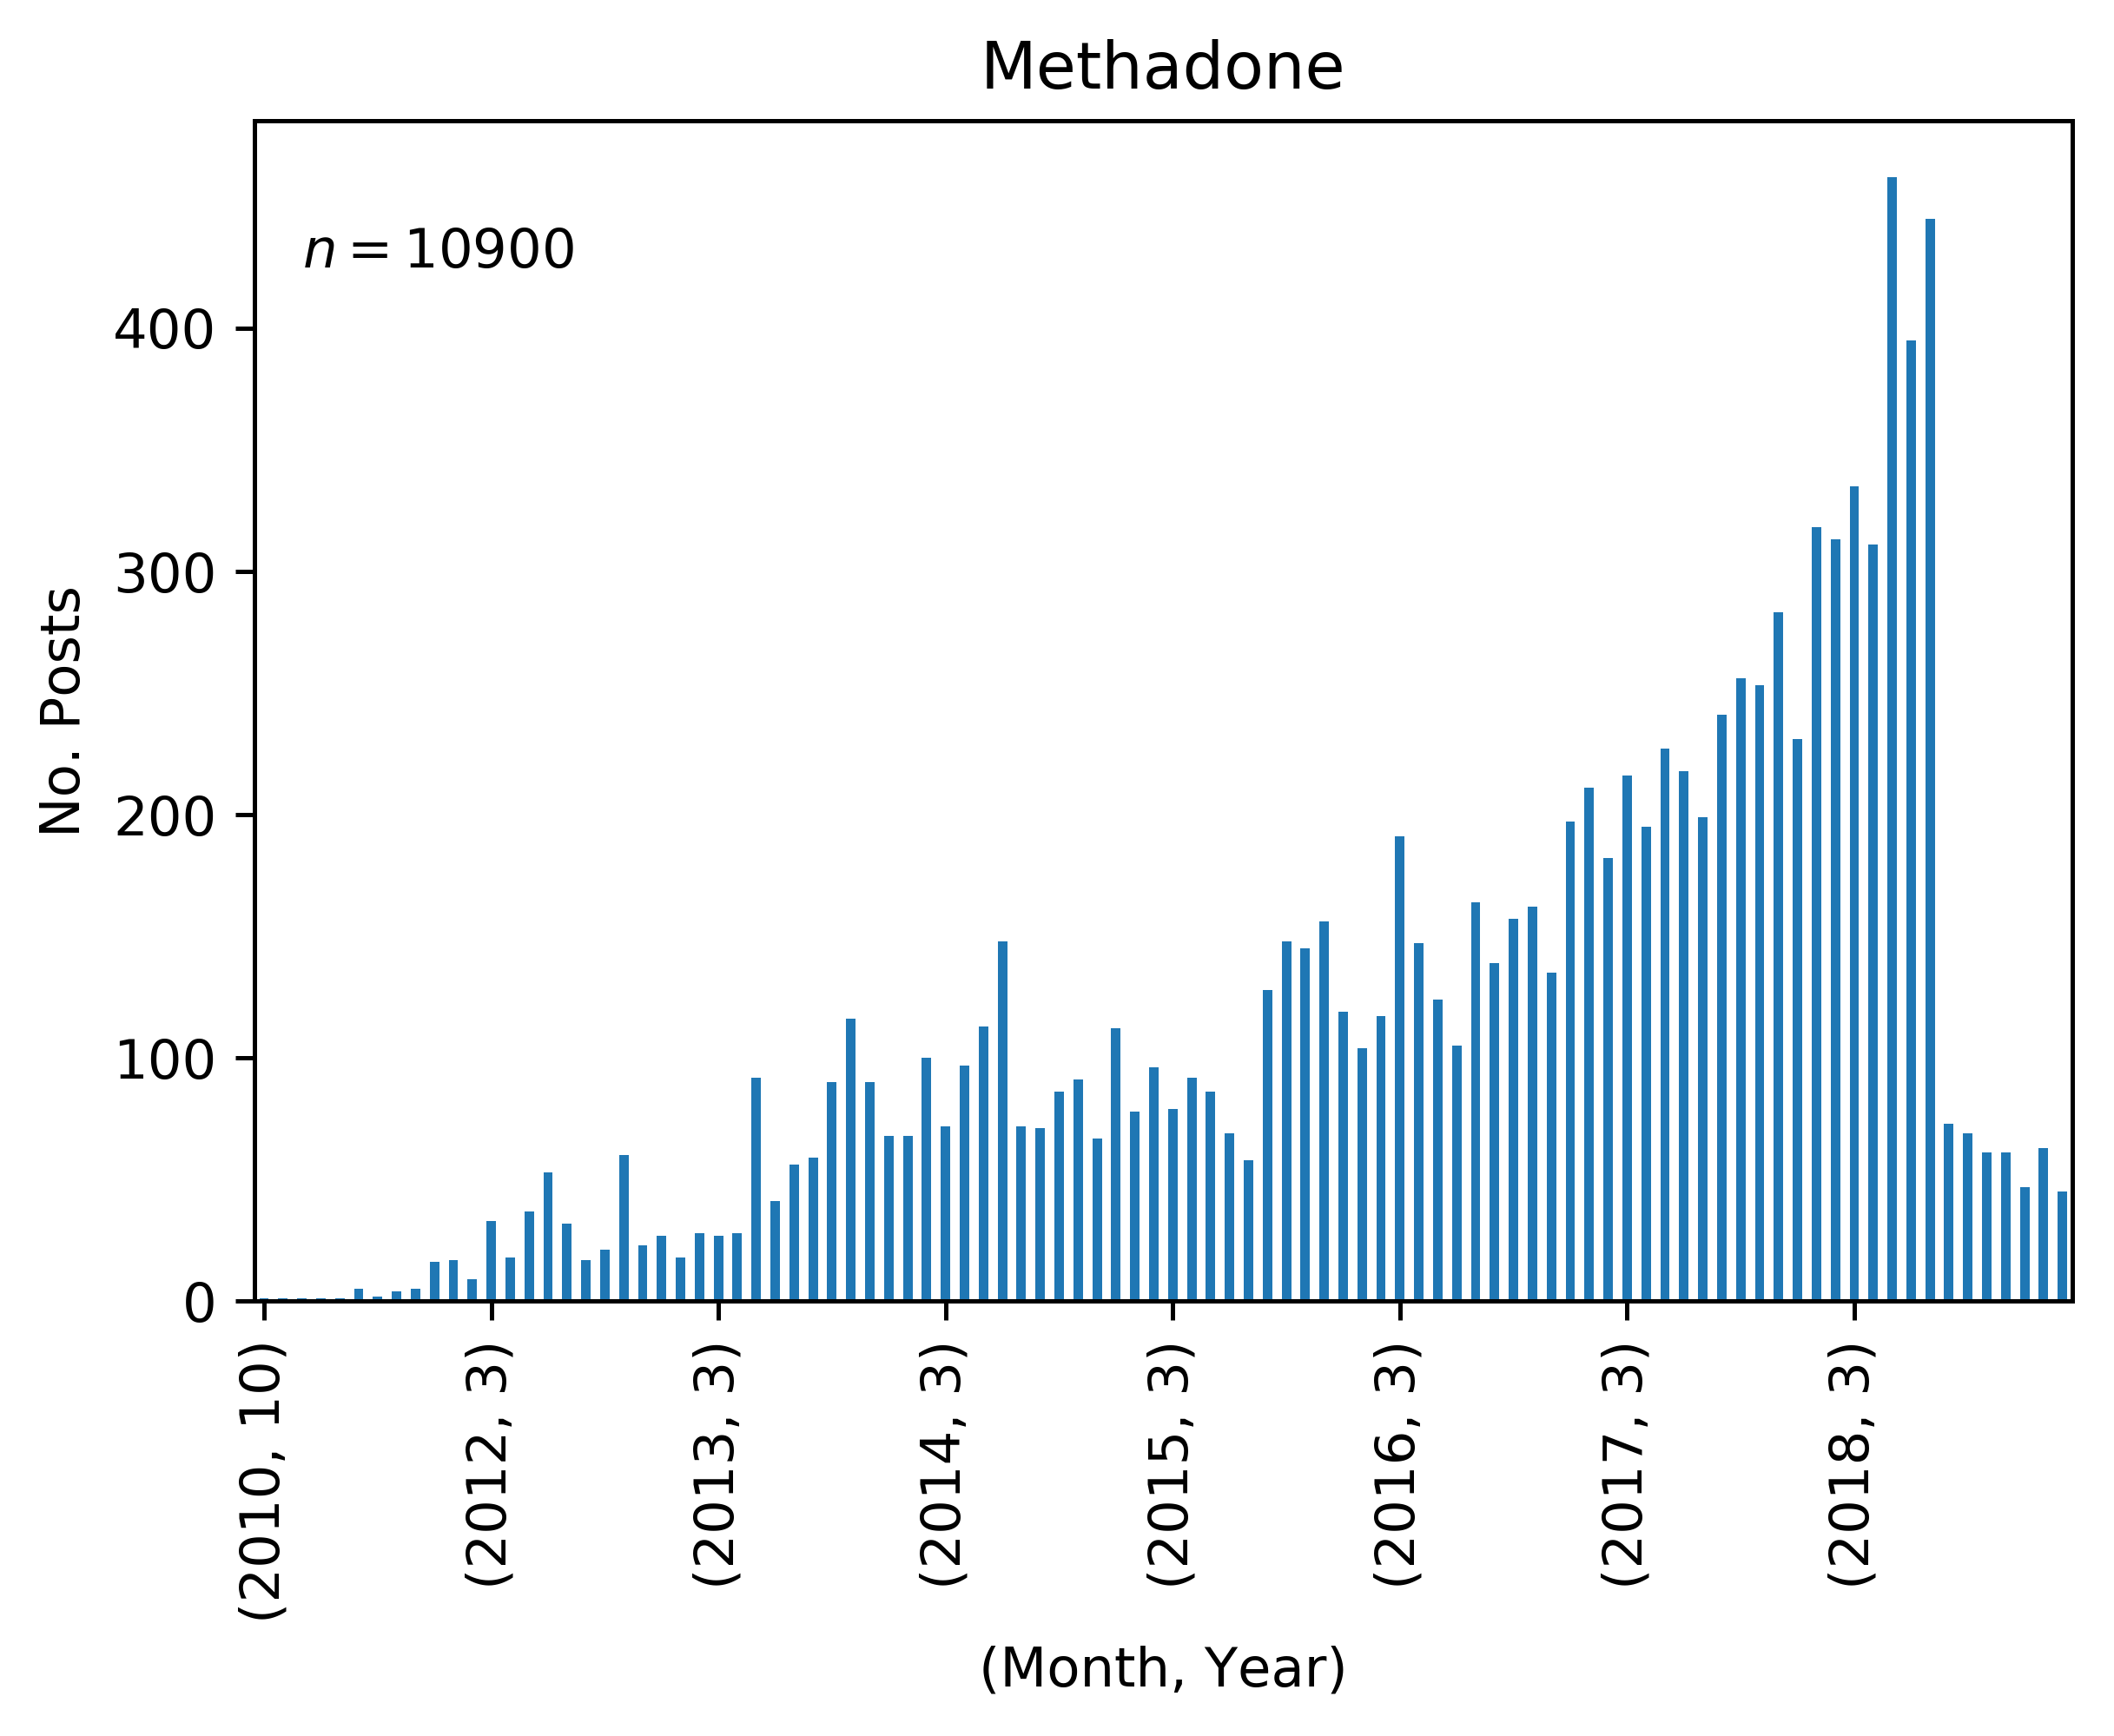

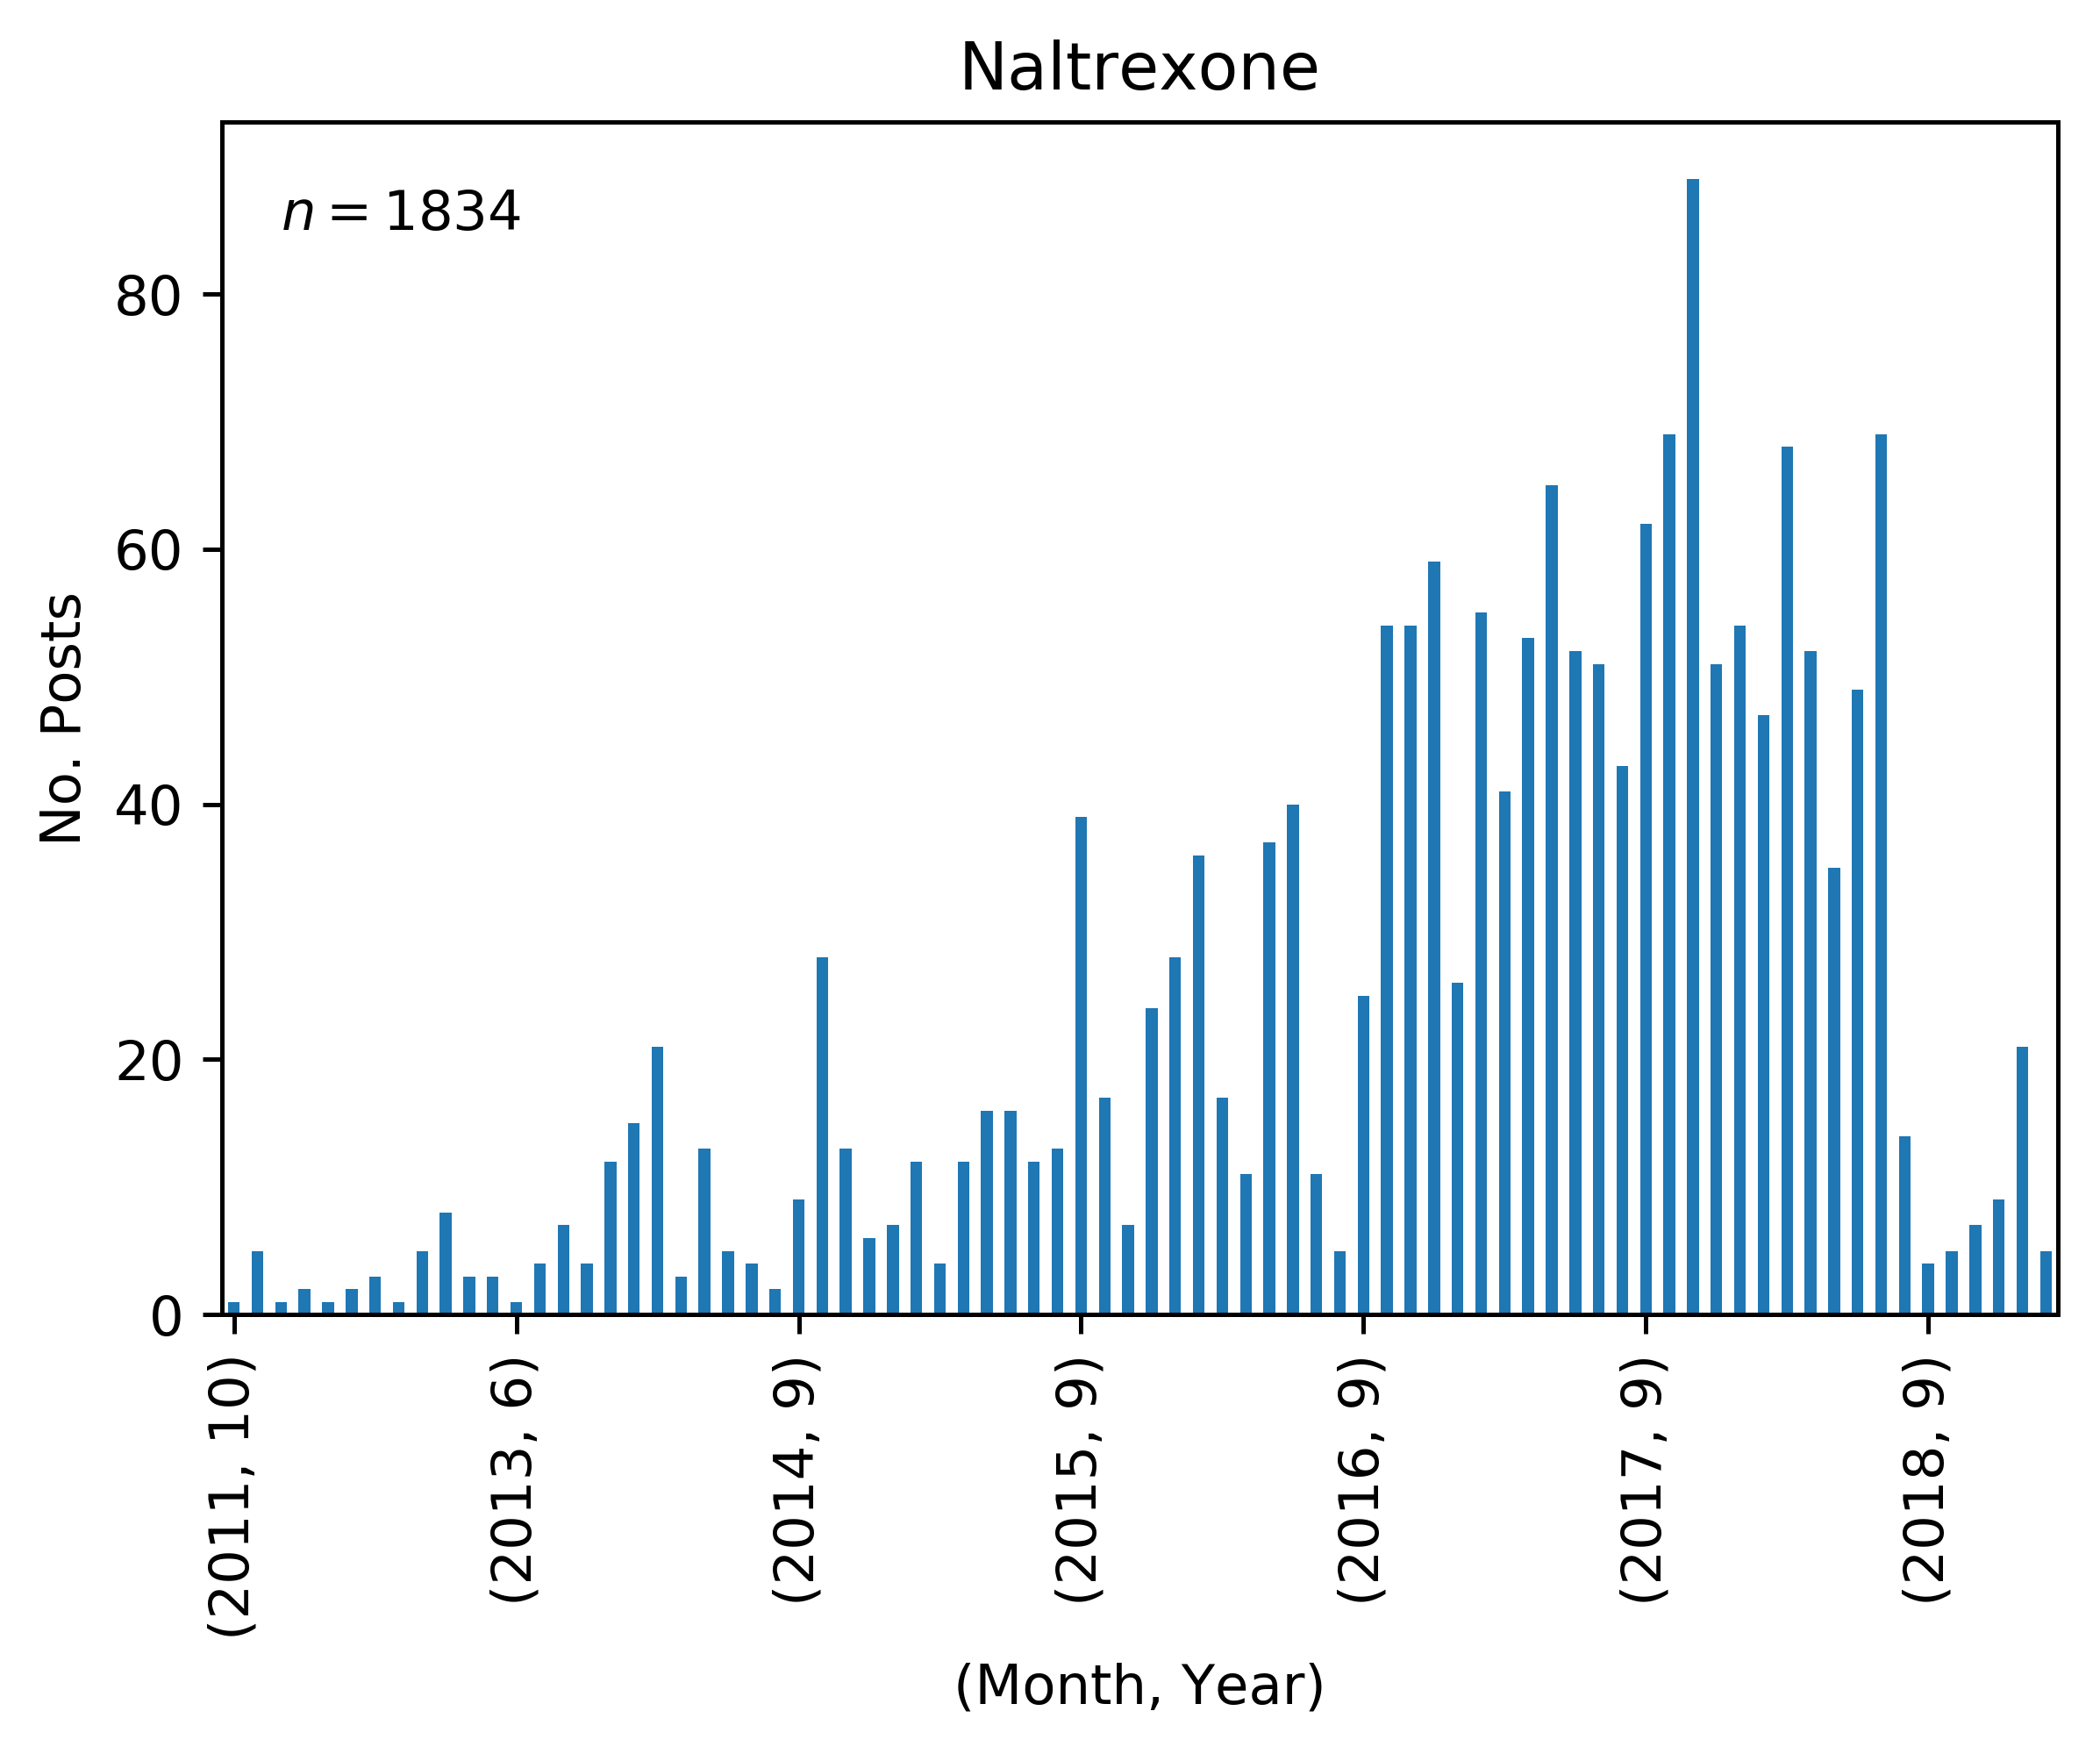

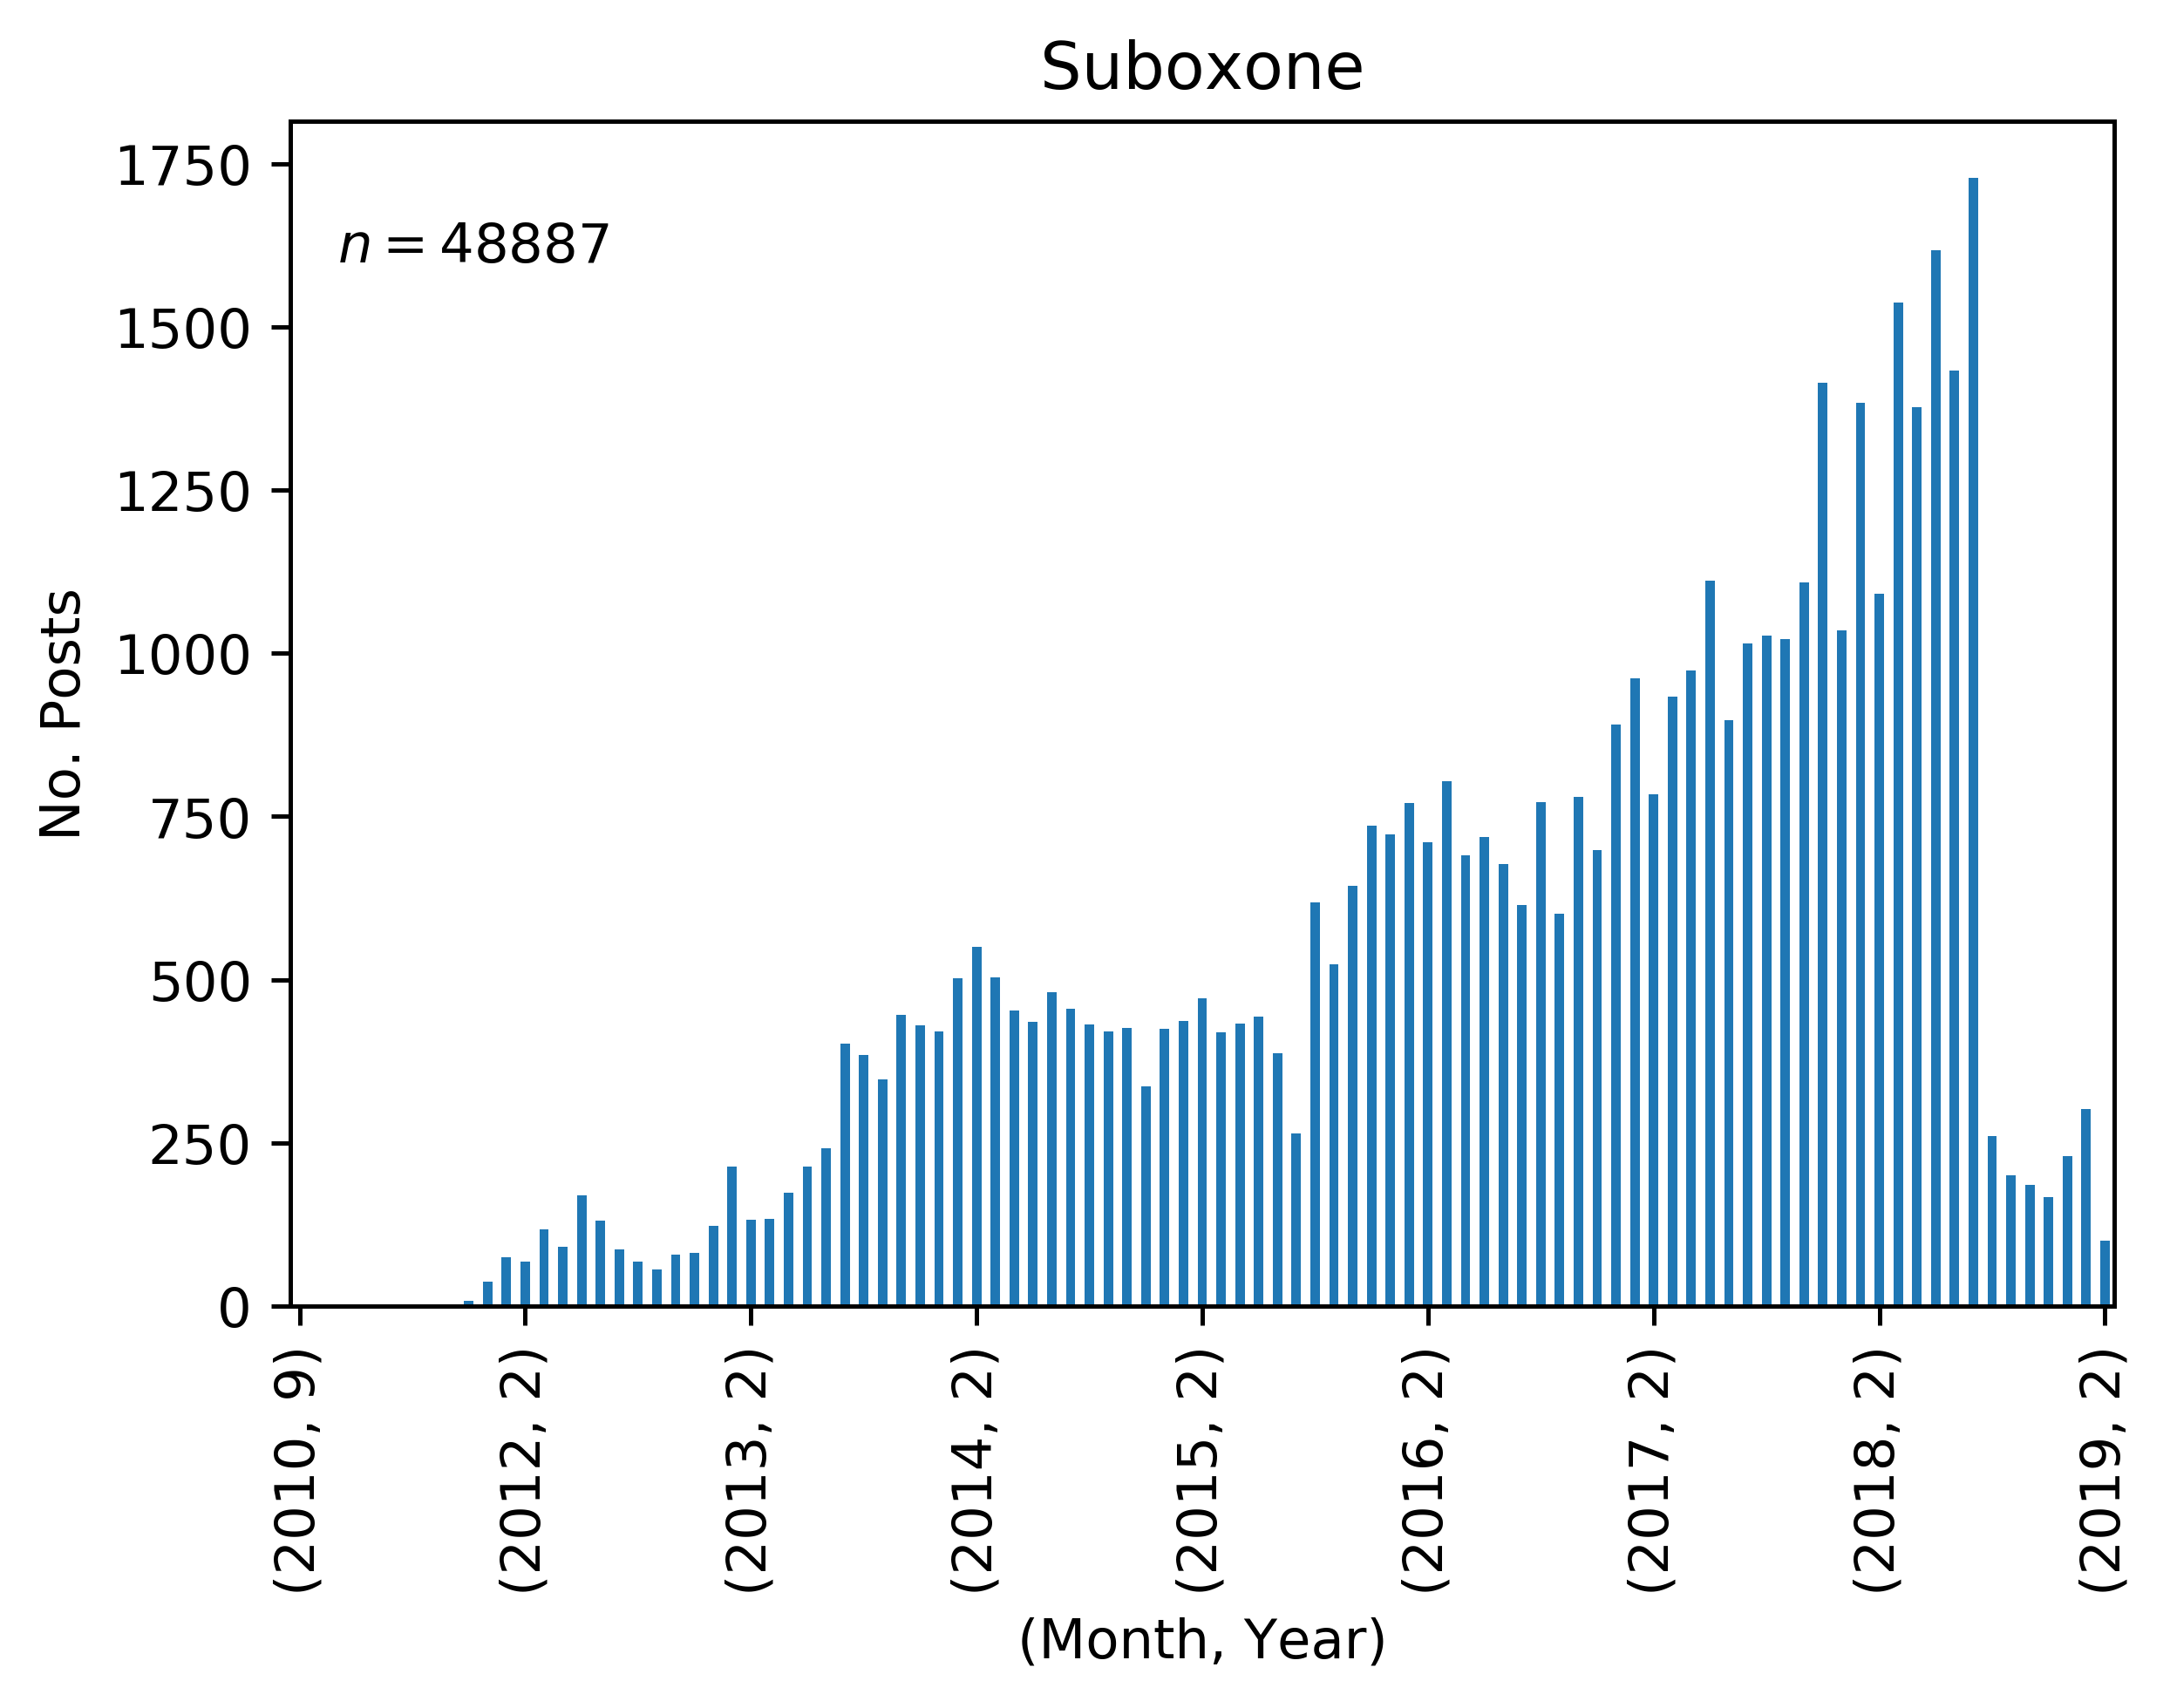

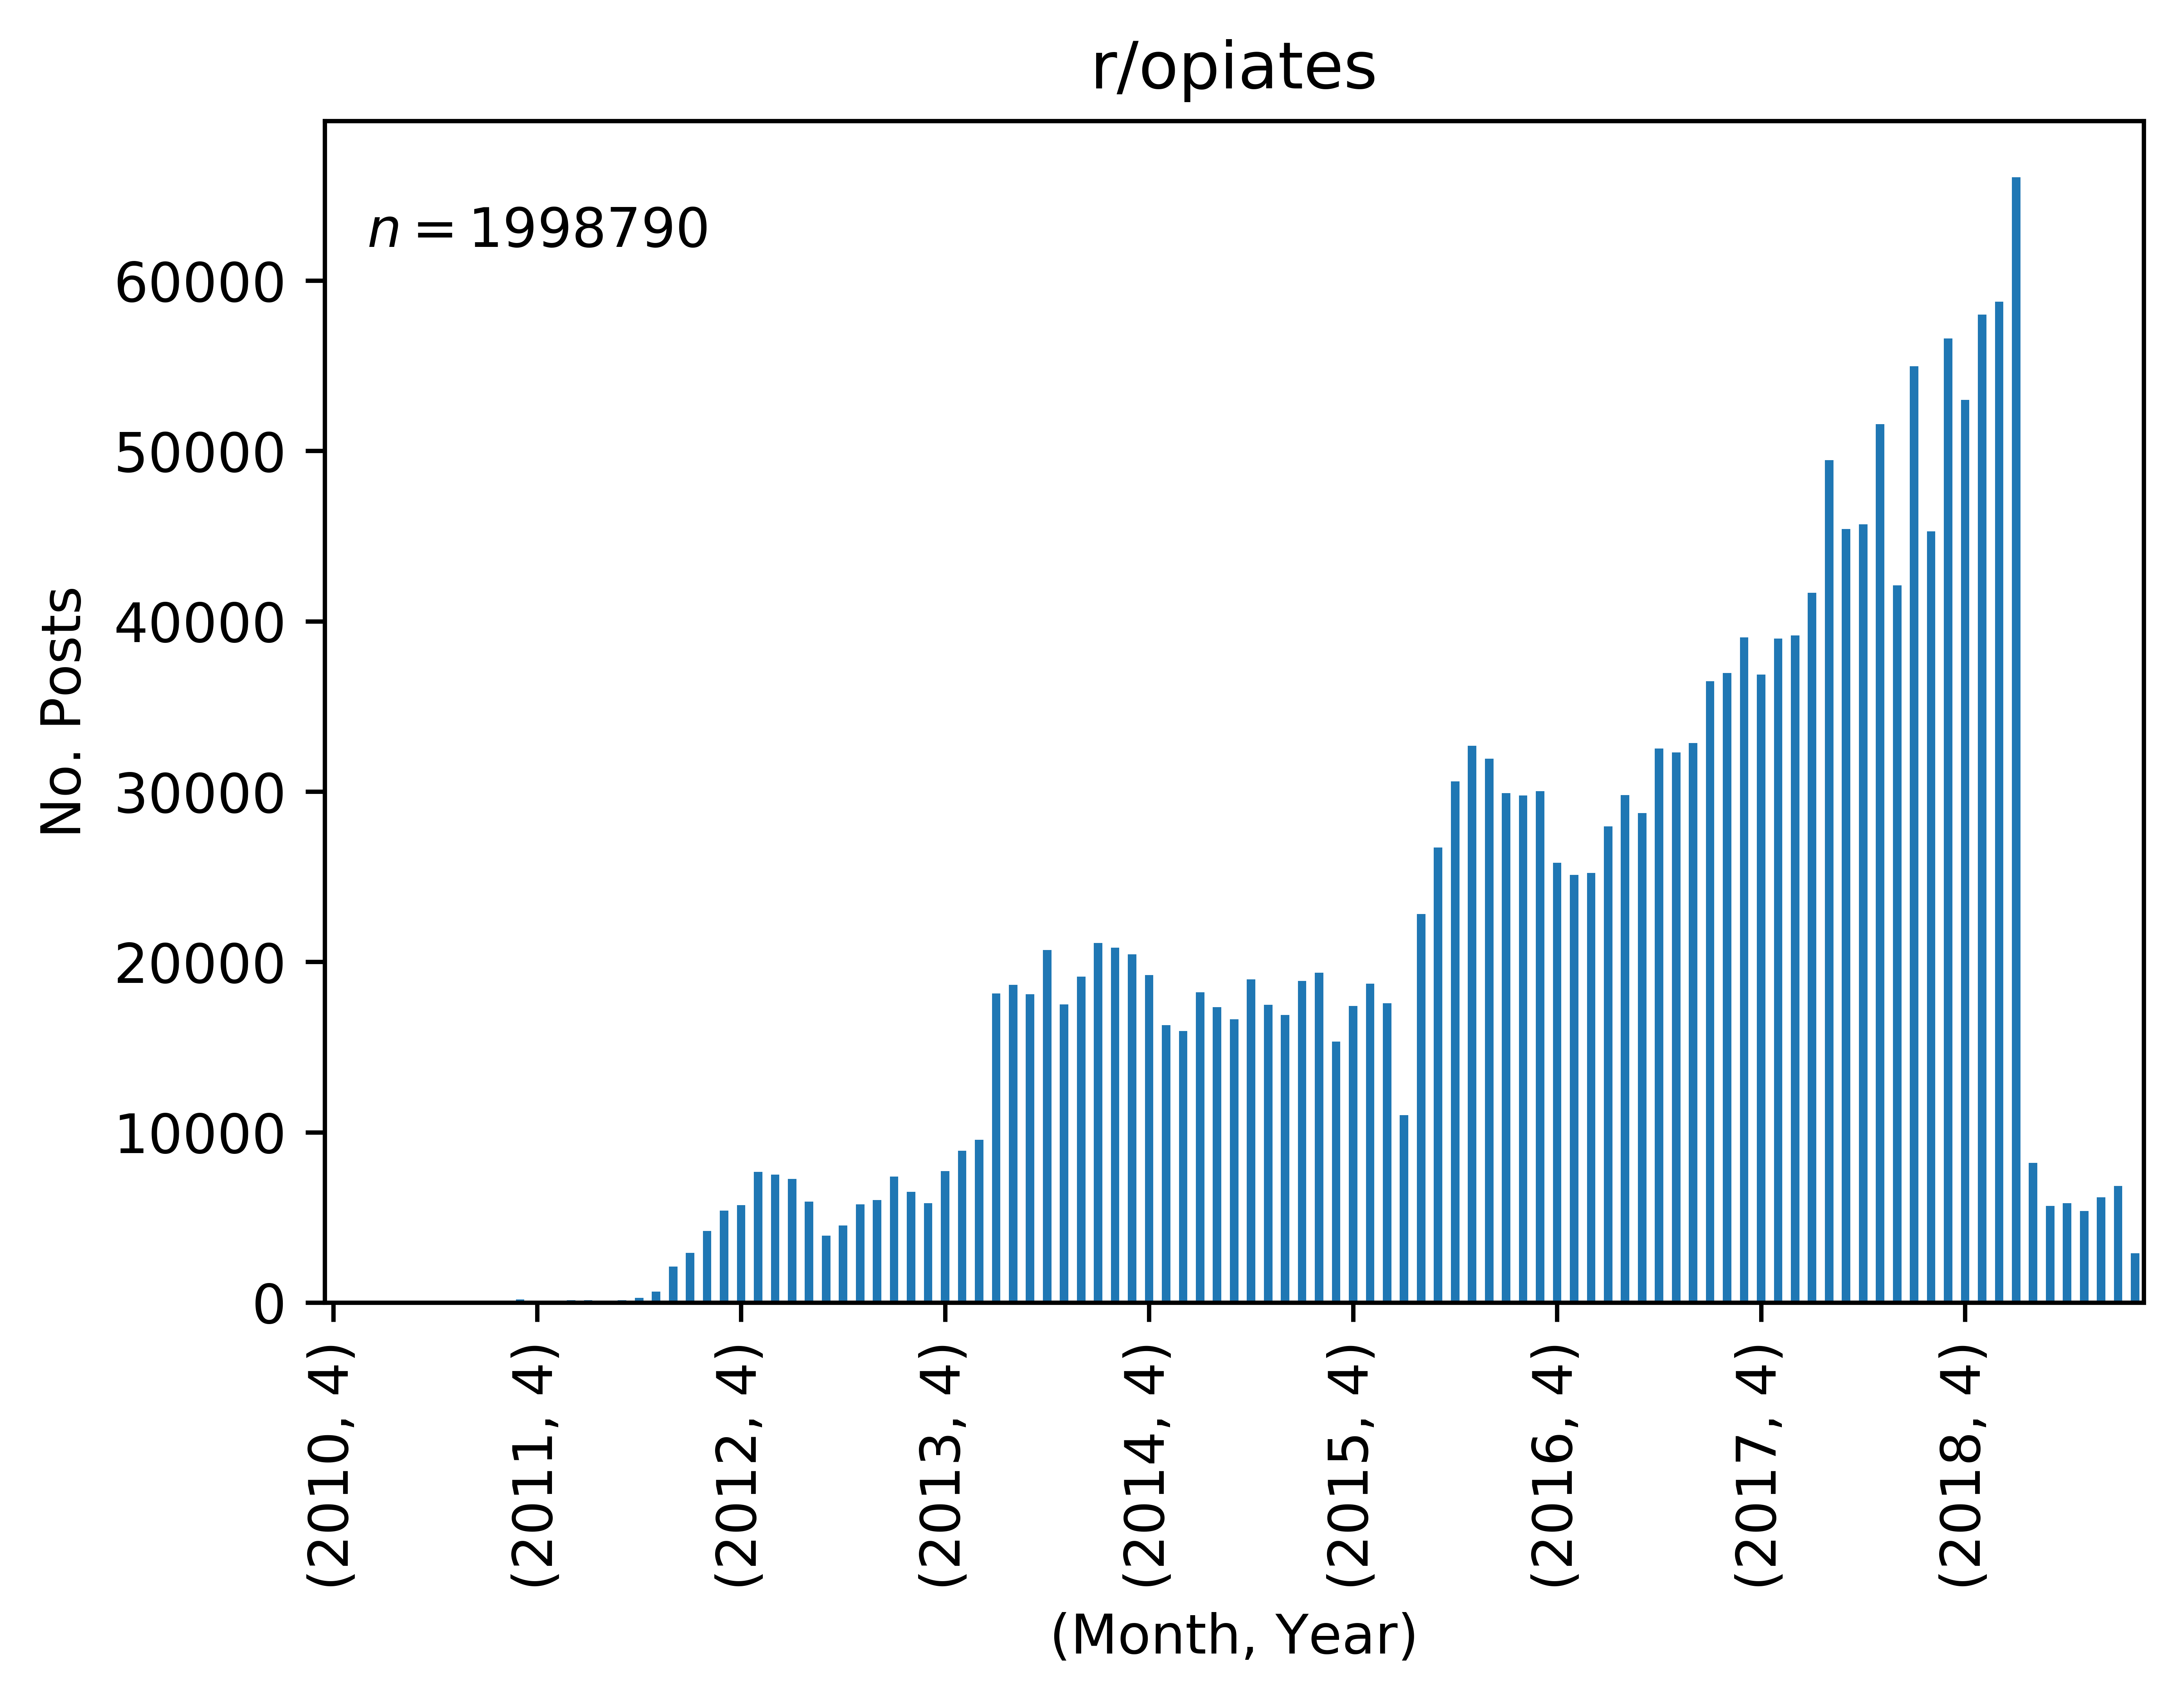

In [62]:
narc_count_hist = narc_only_df['date'].groupby([narc_only_df["date"].dt.year, narc_only_df["date"].dt.month]).count().plot(kind="bar")

n = 12
n_posts = len(narc_only_df.index)
ticks = narc_count_hist.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in narc_count_hist.xaxis.get_ticklabels()]
narc_count_hist.xaxis.set_ticks(ticks[::n])
narc_count_hist.xaxis.set_ticklabels(ticklabels[::n])
narc_count_hist.set_title('Naloxone')
narc_count_hist.set_xlabel('(Month, Year)')
narc_count_hist.set_ylabel('No. Posts')
narc_count_hist.text(2, 300, '$n=%s$ ' % n_posts)


plt.rcParams['figure.dpi'] = 450 # default for me was 75
plt.show()


meth_count_hist = meth_only_df['date'].groupby([meth_only_df["date"].dt.year, meth_only_df["date"].dt.month]).count().plot(kind="bar")


n = 12
n_posts = len(meth_only_df.index)
ticks = meth_count_hist.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in meth_count_hist.xaxis.get_ticklabels()]
meth_count_hist.xaxis.set_ticks(ticks[::n])
meth_count_hist.xaxis.set_ticklabels(ticklabels[::n])
meth_count_hist.set_title('Methadone')
meth_count_hist.set_xlabel('(Month, Year)')
meth_count_hist.set_ylabel('No. Posts')
meth_count_hist.text(2, 425, '$n=%s$ ' % n_posts)

plt.rcParams['figure.dpi'] = 450 # default for me was 75
plt.show()


nalt_count_hist = nalt_only_df['date'].groupby([nalt_only_df["date"].dt.year, nalt_only_df["date"].dt.month]).count().plot(kind="bar")

n = 12
n_posts = len(nalt_only_df.index)
ticks = nalt_count_hist.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in nalt_count_hist.xaxis.get_ticklabels()]
nalt_count_hist.xaxis.set_ticks(ticks[::n])
nalt_count_hist.xaxis.set_ticklabels(ticklabels[::n])
nalt_count_hist.set_title('Naltrexone')
nalt_count_hist.set_xlabel('(Month, Year)')
nalt_count_hist.set_ylabel('No. Posts')
nalt_count_hist.text(2, 85, '$n=%s$ ' % n_posts)


plt.rcParams['figure.dpi'] = 450 # default for me was 75
plt.show()

sub_count_hist = sub_only_df['date'].groupby([sub_only_df["date"].dt.year, sub_only_df["date"].dt.month]).count().plot(kind="bar")

n = 12
n_posts = len(sub_only_df.index)
ticks = sub_count_hist.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in sub_count_hist.xaxis.get_ticklabels()]
sub_count_hist.xaxis.set_ticks(ticks[::n])
sub_count_hist.xaxis.set_ticklabels(ticklabels[::n])
sub_count_hist.set_title('Suboxone')
sub_count_hist.set_xlabel('(Month, Year)')
sub_count_hist.set_ylabel('No. Posts')
sub_count_hist.text(2, 1600, '$n=%s$ ' % n_posts)


plt.rcParams['figure.dpi'] = 1000 # default for me was 75
plt.show()

all_count_hist = reddit_df['date'].groupby([reddit_df["date"].dt.year, reddit_df["date"].dt.month]).count().plot(kind="bar")

n = 12
n_posts = len(reddit_df.index)
ticks = all_count_hist.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in all_count_hist.xaxis.get_ticklabels()]
all_count_hist.xaxis.set_ticks(ticks[::n])
all_count_hist.xaxis.set_ticklabels(ticklabels[::n])
all_count_hist.set_title('r/opiates')
all_count_hist.set_xlabel('(Month, Year)')
all_count_hist.set_ylabel('No. Posts')
all_count_hist.text(2, 62000, '$n=%s$ ' % n_posts)


plt.rcParams['figure.dpi'] = 1000 # default for me was 75
plt.show()

In [ ]:
narc_df_nonzero['post_body_tokens'] = narc_df_nonzero['post_body'].apply(word_tokenize)
narc_df_nonzero['post_body_tokens'] = narc_df_nonzero['post_body_tokens'].apply(lambda x: [item.lower() for item in x if item.lower() not in stop_all])
narc_df_nonzero['post_body_stemmed']=narc_df_nonzero['post_body_tokens'].apply(lambda x : [porter_stemmer.stem(y) for y in x])

### Drug Pricing DataFrames

Because of the high volume of potential locations, it is most efficient to apply other filters, remove non-matching features/observations and then filter for locations

In [18]:
price_df = convert_key_word_threads_to_df(reddit_df, currencies, price_re, case_sensitive=False)

Number of strings searched: 1998790
Number of keywords searching for: 3
Starting time: 2019-02-15 09:27:10.823657
Word 1 out of 3
Time elapsed: 0:00:00.000913
Word 2 out of 3
Time elapsed: 0:00:30.230875
Word 3 out of 3
Time elapsed: 0:00:58.604638


In [19]:
price_df_nonzero = price_df.loc[:, (price_df != 0).any(axis=0)]
price_df_nonzero = price_df_nonzero[price_df_nonzero.select_dtypes([bool]).any(1)]

In [20]:
unit_df = convert_key_word_threads_to_df(price_df_nonzero, units, general_re, case_sensitive=False)
unit_df_nonzero = unit_df.loc[:, (unit_df != 0).any(axis=0)]

Number of strings searched: 24895
Number of keywords searching for: 67
Starting time: 2019-02-15 09:29:15.055504
Word 1 out of 67
Time elapsed: 0:00:02.493307


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Word 2 out of 67
Time elapsed: 0:00:03.782543
Word 3 out of 67
Time elapsed: 0:00:04.348075
Word 4 out of 67
Time elapsed: 0:00:04.944165
Word 5 out of 67
Time elapsed: 0:00:05.593054
Word 6 out of 67
Time elapsed: 0:00:06.219981
Word 7 out of 67
Time elapsed: 0:00:06.883102
Word 8 out of 67
Time elapsed: 0:00:07.582070
Word 9 out of 67
Time elapsed: 0:00:08.316077
Word 10 out of 67
Time elapsed: 0:00:09.114100
Word 11 out of 67
Time elapsed: 0:00:09.880588
Word 12 out of 67
Time elapsed: 0:00:10.688079
Word 13 out of 67
Time elapsed: 0:00:11.556355
Word 14 out of 67
Time elapsed: 0:00:12.406743
Word 15 out of 67
Time elapsed: 0:00:13.298094
Word 16 out of 67
Time elapsed: 0:00:14.226163
Word 17 out of 67
Time elapsed: 0:00:15.144866
Word 18 out of 67
Time elapsed: 0:00:16.074431
Word 19 out of 67
Time elapsed: 0:00:17.096222
Word 20 out of 67
Time elapsed: 0:00:18.091103
Word 21 out of 67
Time elapsed: 0:00:19.141759
Word 22 out of 67
Time elapsed: 0:00:20.238015
Word 23 out of 67
Tim

In [21]:
location_df = convert_key_word_threads_to_df(unit_df_nonzero, locations, general_re, case_sensitive=False)
location_df_nonzero = location_df.loc[:, (location_df != 0).any(axis=0)]

Number of strings searched: 24895
Number of keywords searching for: 774
Starting time: 2019-02-15 09:31:17.934801
Word 1 out of 774
Time elapsed: 0:00:00.000298


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Word 2 out of 774
Time elapsed: 0:00:03.017173
Word 3 out of 774
Time elapsed: 0:00:05.729115
Word 4 out of 774
Time elapsed: 0:00:08.245330
Word 5 out of 774
Time elapsed: 0:00:10.804162
Word 6 out of 774
Time elapsed: 0:00:12.857306
Word 7 out of 774
Time elapsed: 0:00:15.102164
Word 8 out of 774
Time elapsed: 0:00:17.398242
Word 9 out of 774
Time elapsed: 0:00:19.721913
Word 10 out of 774
Time elapsed: 0:00:22.073586
Word 11 out of 774
Time elapsed: 0:00:24.442221
Word 12 out of 774
Time elapsed: 0:00:27.132657
Word 13 out of 774
Time elapsed: 0:00:29.513774
Word 14 out of 774
Time elapsed: 0:00:31.940098
Word 15 out of 774
Time elapsed: 0:00:34.410029
Word 16 out of 774
Time elapsed: 0:00:37.178179
Word 17 out of 774
Time elapsed: 0:00:39.660795
Word 18 out of 774
Time elapsed: 0:00:42.255125
Word 19 out of 774
Time elapsed: 0:00:44.773804
Word 20 out of 774
Time elapsed: 0:00:47.356121
Word 21 out of 774
Time elapsed: 0:00:49.925791
Word 22 out of 774
Time elapsed: 0:00:52.509825


Word 172 out of 774
Time elapsed: 0:12:31.700529
Word 173 out of 774
Time elapsed: 0:12:37.367369
Word 174 out of 774
Time elapsed: 0:12:43.024723
Word 175 out of 774
Time elapsed: 0:12:49.868742
Word 176 out of 774
Time elapsed: 0:12:58.554693
Word 177 out of 774
Time elapsed: 0:13:04.366139
Word 178 out of 774
Time elapsed: 0:13:17.953735
Word 179 out of 774
Time elapsed: 0:13:24.939550
Word 180 out of 774
Time elapsed: 0:13:35.999472
Word 181 out of 774
Time elapsed: 0:13:45.718769
Word 182 out of 774
Time elapsed: 0:13:57.623496
Word 183 out of 774
Time elapsed: 0:14:08.166857
Word 184 out of 774
Time elapsed: 0:14:19.970999
Word 185 out of 774
Time elapsed: 0:14:33.892539
Word 186 out of 774
Time elapsed: 0:14:47.996580
Word 187 out of 774
Time elapsed: 0:15:01.918438
Word 188 out of 774
Time elapsed: 0:15:17.240668
Word 189 out of 774
Time elapsed: 0:15:31.889917
Word 190 out of 774
Time elapsed: 0:15:48.298452
Word 191 out of 774
Time elapsed: 0:16:04.741405
Word 192 out of 774


Word 340 out of 774
Time elapsed: 0:38:35.832949
Word 341 out of 774
Time elapsed: 0:38:47.086927
Word 342 out of 774
Time elapsed: 0:38:59.767668
Word 343 out of 774
Time elapsed: 0:39:10.191322
Word 344 out of 774
Time elapsed: 0:39:19.768800
Word 345 out of 774
Time elapsed: 0:39:30.813412
Word 346 out of 774
Time elapsed: 0:39:40.380464
Word 347 out of 774
Time elapsed: 0:39:50.063612
Word 348 out of 774
Time elapsed: 0:39:59.674078
Word 349 out of 774
Time elapsed: 0:40:09.740401
Word 350 out of 774
Time elapsed: 0:40:19.372125
Word 351 out of 774
Time elapsed: 0:40:29.093774
Word 352 out of 774
Time elapsed: 0:40:38.813270
Word 353 out of 774
Time elapsed: 0:40:48.531524
Word 354 out of 774
Time elapsed: 0:40:58.166351
Word 355 out of 774
Time elapsed: 0:41:07.981720
Word 356 out of 774
Time elapsed: 0:41:17.772073
Word 357 out of 774
Time elapsed: 0:41:28.604793
Word 358 out of 774
Time elapsed: 0:41:39.719454
Word 359 out of 774
Time elapsed: 0:41:49.981408
Word 360 out of 774


Word 508 out of 774
Time elapsed: 1:12:44.952919
Word 509 out of 774
Time elapsed: 1:13:01.222259
Word 510 out of 774
Time elapsed: 1:13:15.356906
Word 511 out of 774
Time elapsed: 1:13:29.238892
Word 512 out of 774
Time elapsed: 1:13:43.019389
Word 513 out of 774
Time elapsed: 1:13:56.836736
Word 514 out of 774
Time elapsed: 1:14:11.460866
Word 515 out of 774
Time elapsed: 1:14:25.913328
Word 516 out of 774
Time elapsed: 1:14:39.689060
Word 517 out of 774
Time elapsed: 1:14:57.378751
Word 518 out of 774
Time elapsed: 1:15:11.373860
Word 519 out of 774
Time elapsed: 1:15:25.905854
Word 520 out of 774
Time elapsed: 1:15:39.979004
Word 521 out of 774
Time elapsed: 1:15:54.269784
Word 522 out of 774
Time elapsed: 1:16:07.951236
Word 523 out of 774
Time elapsed: 1:16:22.326838
Word 524 out of 774
Time elapsed: 1:16:35.869385
Word 525 out of 774
Time elapsed: 1:16:49.324302
Word 526 out of 774
Time elapsed: 1:17:04.252869
Word 527 out of 774
Time elapsed: 1:17:19.014398
Word 528 out of 774


Word 676 out of 774
Time elapsed: 1:59:02.954335
Word 677 out of 774
Time elapsed: 1:59:20.526375
Word 678 out of 774
Time elapsed: 1:59:37.416015
Word 679 out of 774
Time elapsed: 1:59:54.265011
Word 680 out of 774
Time elapsed: 2:00:11.223281
Word 681 out of 774
Time elapsed: 2:00:28.004492
Word 682 out of 774
Time elapsed: 2:00:46.344148
Word 683 out of 774
Time elapsed: 2:01:03.248651
Word 684 out of 774
Time elapsed: 2:01:20.133951
Word 685 out of 774
Time elapsed: 2:01:37.133112
Word 686 out of 774
Time elapsed: 2:01:54.122078
Word 687 out of 774
Time elapsed: 2:02:11.855335
Word 688 out of 774
Time elapsed: 2:02:29.448250
Word 689 out of 774
Time elapsed: 2:02:46.768681
Word 690 out of 774
Time elapsed: 2:03:03.799080
Word 691 out of 774
Time elapsed: 2:03:22.709021
Word 692 out of 774
Time elapsed: 2:03:41.191665
Word 693 out of 774
Time elapsed: 2:03:59.221411
Word 694 out of 774
Time elapsed: 2:04:17.453937
Word 695 out of 774
Time elapsed: 2:04:35.784328
Word 696 out of 774


Define a column of the matched words

In [22]:
len(location_df_nonzero)

24895

In [23]:
location location_df.apply(lambda x: location_df.columns[x == True].values, axis=1)

SyntaxError: invalid syntax (<ipython-input-23-33920971d723>, line 1)

In [24]:
# location_df['Matches'] = location_df.eq(True).dot(location_df.columns+',').str[:-1].str.split()
#location_df.drop(["No. Matches"], axis=1)
location_df['Matches'] = location_df.eq(True).dot(location_df.columns+',').str[:-1].str.split(',')

In [25]:
location_df['No. Matches'] = location_df['Matches'].str.len()

In [32]:
location_df['No. Matches'] = location_df['Matches'].apply(lambda x: len(x))

In [34]:
location_df_3_matches = location_df.loc[location_df['No. Matches'] > 2]

In [35]:
location_df_3_matches

,time,post_id,reply_id,no_comments,comment_id,post_title,post_body,€,£,$,...,Hyde Park,WA,Lafayette,TX,Carlsbad,Liverpool,Waco,Hangzhou,Matches,No. Matches
231,1489945877.0,60bc7y,NaN,13,NaN,3-4 days of sickness incoming,"so, i got paid on friday. put in a darknet order for $100 worth of dope that will last me a week or two. also hit up my connect and voluntarily fucked myself on the ridiculous prices of heroin just to keep from being sick over the weekend. its good shit too but if i am paying $140 a gram that shit needs to last weeks not days. anyway, i was expecting to get my shipment monday but it will be wednesday (or god forbid thurs). so this is day 1. f...",False,False,True,...,False,False,False,False,False,False,False,False,"[$, gram, point]",3
658,1446904490.0,3rvz5u,NaN,272,NaN,junkie blow job,"throwaway since i dont wana use my normal account for this. so i am driving around ptown this morning looking for some yay with one of my buddies. i dont do opiates but i love some good white. we are driving around looking for a good spot to cop, junkies everywhere like always in ptown. we pull into a parking spot near our spot and before we can get out of the car this cute girl maybe 25 years old walks up to us looking high out of her mind. ...",False,False,True,...,False,False,False,False,False,False,False,False,"[$, spots, load, spot, lines, L.A.]",6
682,1352794123.0,13441p,NaN,28,NaN,"what's the most you have ever paid for dope? anyone ever had real and i mean real china white? if so, how was it?",my boy says he has a hook on some real china white and i would go with him to get it. we are getting a gram for $300 but he said he shot up the tinyiest amount a he was stuck on the floor all fucked up for hours. like this is the best dope you could possibly get he says so were guna try it i just want to know what people experiences with seriously good dope have been and what's the most they paid for a gram or half gram i don't shoot i usuall...,False,False,True,...,False,False,False,False,False,False,False,False,"[$, gram, half, China]",4
827,1505187475.0,6zkigl,NaN,20,NaN,pricing?,"everytime i pick up from my dealers i (usually percocet 10mg) they charge me $5 a pop. but on previous posts and with previous dealers, when it comes to opiates, it usually goes for $1 per mg. what do you guys pay for when it comes to hydro, oxy, morphine etc. also heroin. been curious about pricing as far as that goes",False,False,True,...,False,False,False,False,False,False,False,False,"[$, pop, posts, mg]",4
978,1406497144.0,2bw04m,NaN,25,NaN,best way to get a script from a doc.,"i'm a 280+ lb 29yr male, work a manual laborish job. i have excellent health insurance so x-rays, mris, cat scans are all like $10. i have an appointment tomorrow with my family practice physician. what do i say effects me? i made the appt on the grounds of ""back pain"" for the past 2 months.",False,False,True,...,False,False,False,False,False,False,False,False,"[$, job, D.C]",3
1331,1446025751.0,3qjh5q,NaN,17,NaN,i'm going to hate myself in a few days,"i seen someone post about overdrawing their bank account from the atm last week or something like that so i decided fuck it i'm gonna do it too. basically i had a second checking account at another bank from the one i use normally. i was going to close it out years ago but never did. well it came in hand as a junkie i guess cause i was able to pull $400 out of thin air lmao. anyways, my dealer is now otw over tshirts $100 should keep me well ...",False,False,True,...,False,False,False,False,False,False,False,False,"[$, bit, post, L.A.]",4
1418,1518233499.0,7wj0jh,NaN,80,NaN,just got robbed,"fucking with a new ""plug"". promised me a g of some fire brown for 150. dude picks me up talking about we got to ride to get it. right off the dick im thinking, great another fucking middle. we arrive at some white junkie bitch's apartment (no offense ladies) where im waiting like 3 hours for dude to call him back. then the call final

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

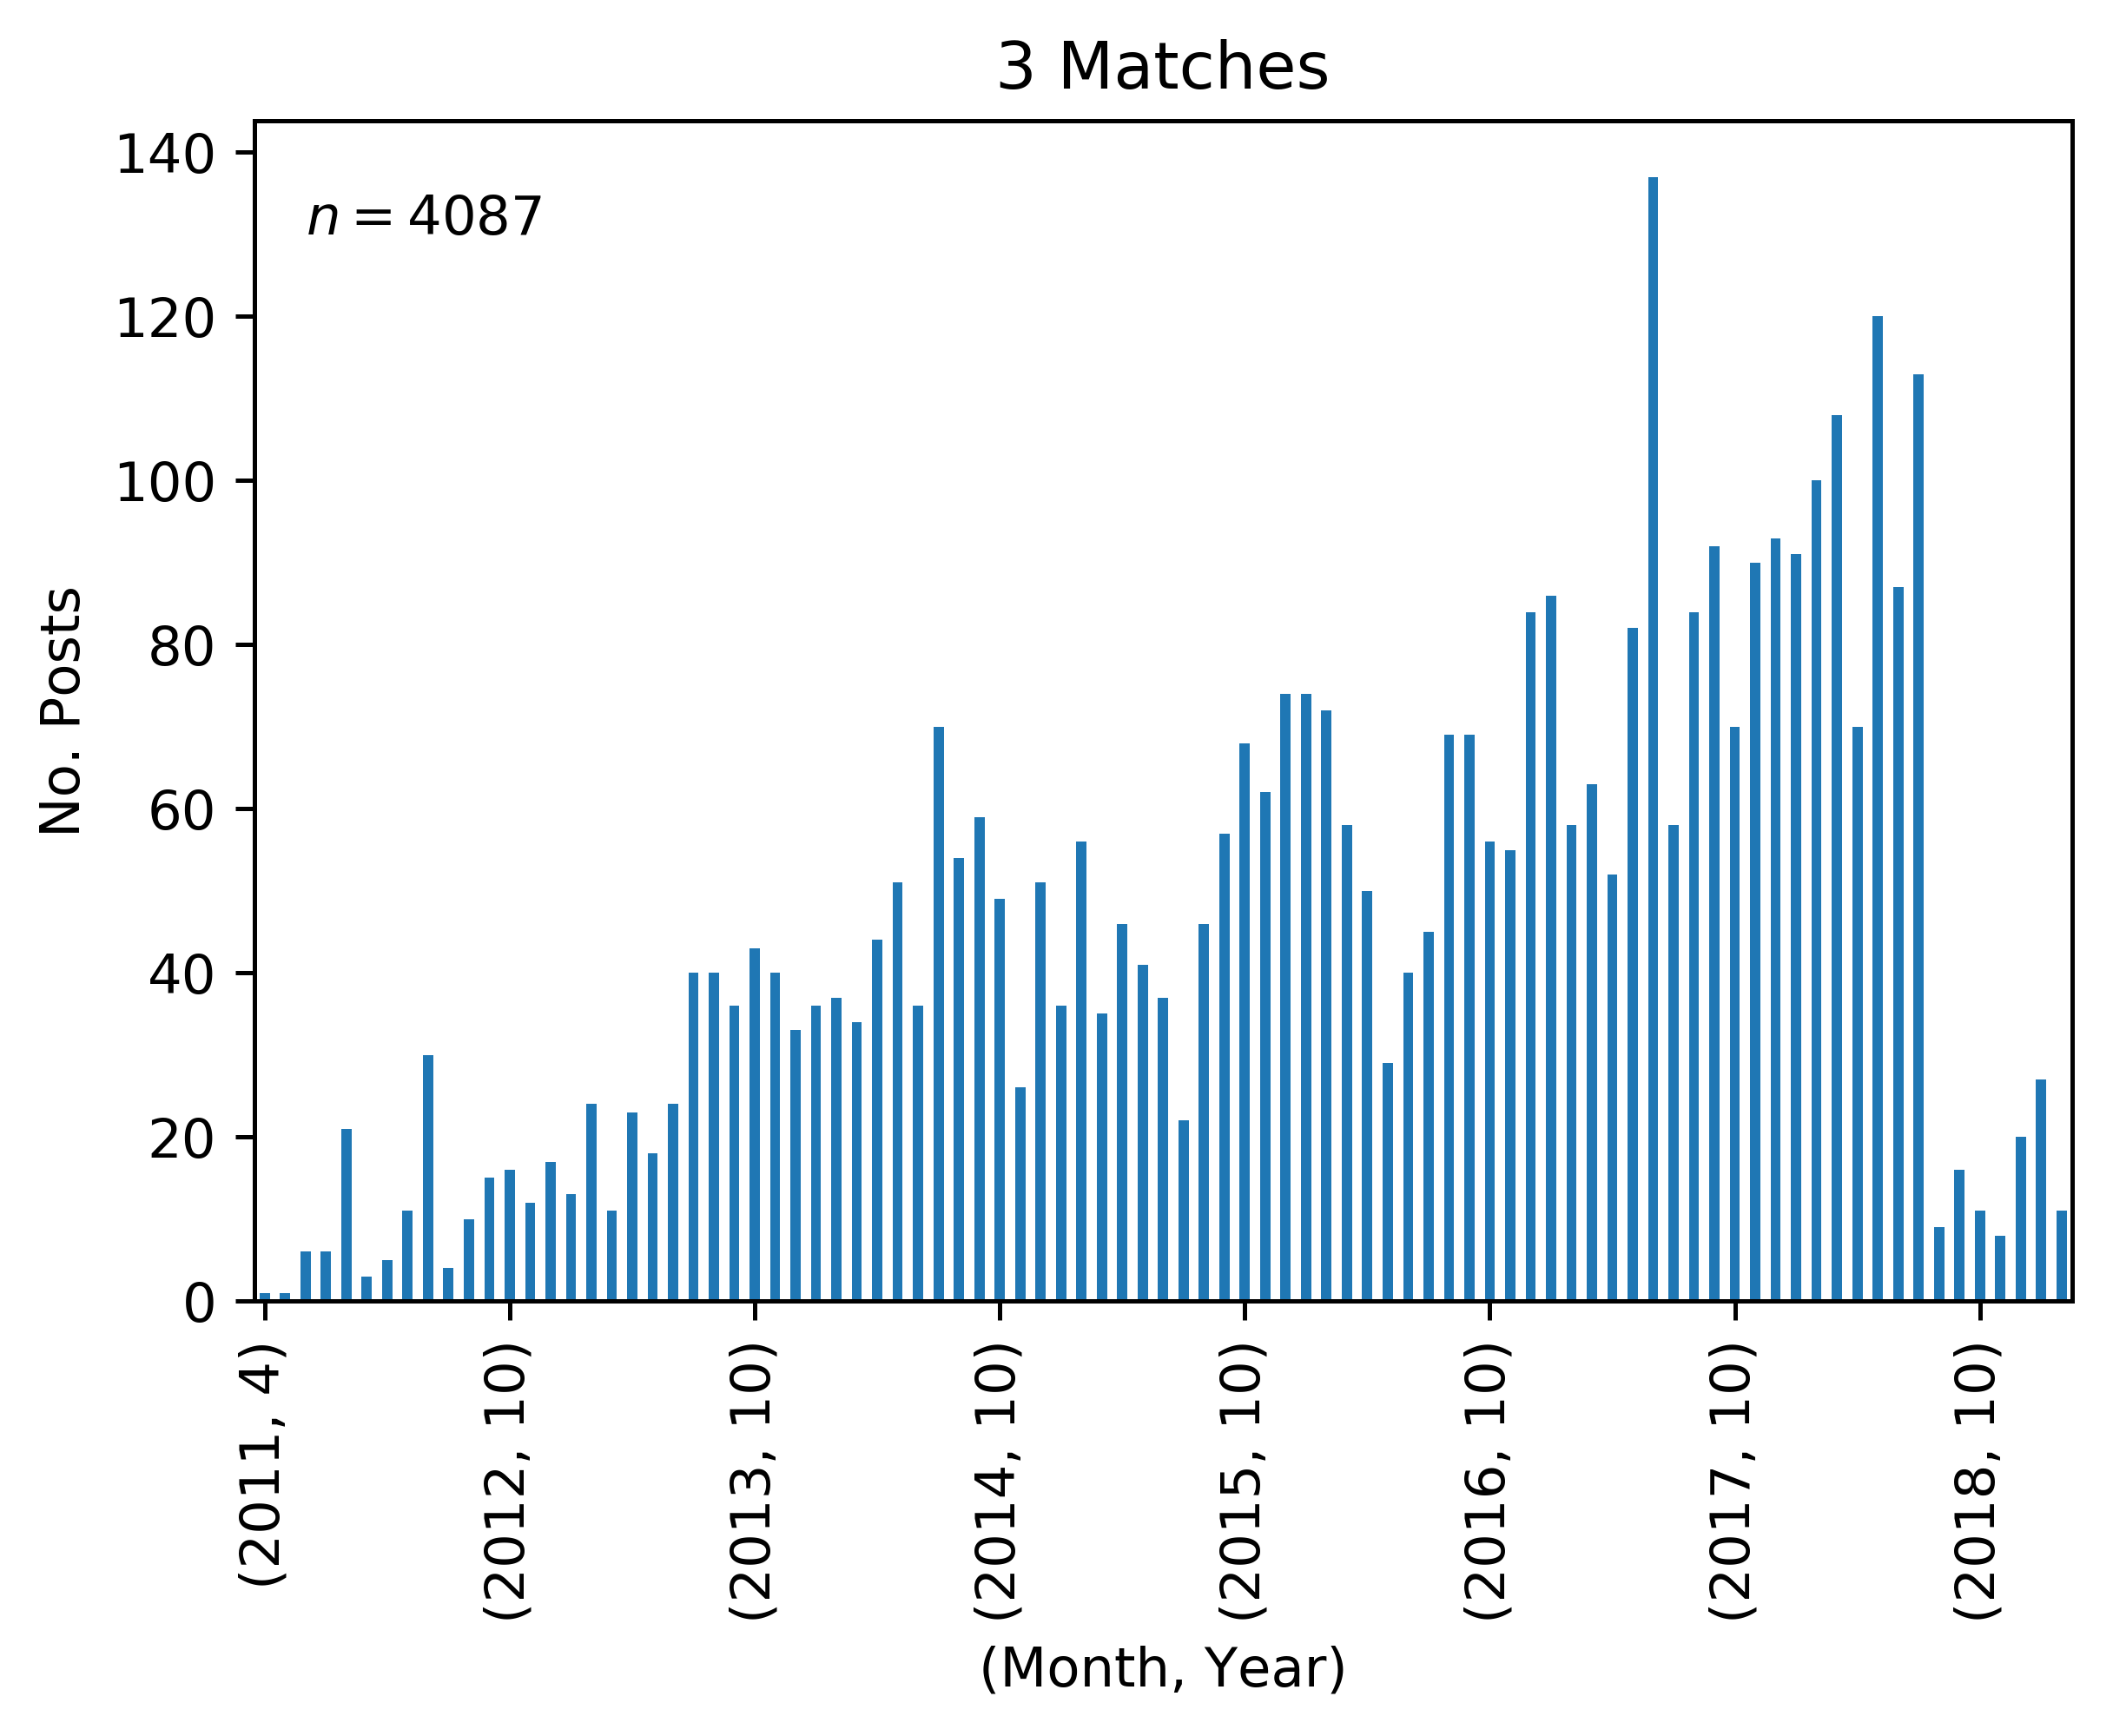

In [69]:
location_df_3_matches['time_new'] = pd.to_datetime(location_df_3_matches['time'], unit='s')
location_df_3_matches['date'] = location_df_3_matches['time_new'].dt.date
location_df_3_matches['time_new'] = pd.to_datetime(location_df_3_matches['time'], unit='s')
location_df_3_matches['time'] = pd.to_numeric(location_df_3_matches['time'])
location_df_3_matches['date'] = pd.to_datetime(location_df_3_matches['time_new'])



location_df_3_match_hist = location_df_3_matches['date'].groupby([location_df_3_matches["date"].dt.year, location_df_3_matches["date"].dt.month]).count().plot(kind="bar")


n = 12
n_posts = len(location_df_3_matches.index)
ticks = location_df_3_match_hist.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in location_df_3_match_hist.xaxis.get_ticklabels()]
location_df_3_match_hist.xaxis.set_ticks(ticks[::n])
location_df_3_match_hist.xaxis.set_ticklabels(ticklabels[::n])
location_df_3_match_hist.set_title('3 Matches')
location_df_3_match_hist.set_xlabel('(Month, Year)')
location_df_3_match_hist.set_ylabel('No. Posts')
location_df_3_match_hist.text(2, 130, '$n=%s$ ' % n_posts)

plt.rcParams['figure.dpi'] = 450 # default for me was 75
plt.show()



In [ ]:
def lambda_1(feature):
    match = ()